<center><i>Łukasz Staniszewski, Łukasz Topolski</i></center>
<h1><center>Mini projekt 5 - SSNE - Rekurencyjny klasyfikator kompozyotrów</center></h1>

## Polecenie
Zadanie polega na stworzeniu modelu rekurencyjnego, który przewidywał będzie kompozytora danego utworu muzyki klasycznej w oparciu o jego zapis w formie sekwencji akordów (akordy znormalizowane zostały do klucza C-dur lub A-mol w zależności od skali utworu -durowa/molowa).
Dane przygotowane są w postaci pickli w pliku train.pkl, w których znajduje się lista krotek z sekwencjami i odpowiadającymi im klasami, czyli autorami odpowiednio: {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}.

W pliku test_no_target znajdują się testowe sekwencje, dla których predykcje są do przewidzenia.

Utwory mogą być różnych długości, stąd też w celu stworzenia batcha danych różnej długości, trzeb je odpowiednio przygotować stosując tzw. padding. Przykładowo można się posiłkować tym tutorialem: https://suzyahyah.github.io/pytorch/2019/07/01/DataLoader-Pad-Pack-Sequence.html.


## Przygotowanie

In [49]:
import pickle
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.utils.class_weight import compute_class_weight

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.is_available()

True

In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(2115)
    torch.cuda.manual_seed_all(2115)

torch.manual_seed(2115)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

## Dane

In [5]:
with open('data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)

with open('data/test_no_target.pkl', 'rb') as f:
    data_test = pickle.load(f)

#### Padding w celu wyrównania sekwencji

In [6]:
train_in = []
train_out = []
test_in = []
max_len = -1

for sample in data_train:
    train_in.append(torch.Tensor(sample[0]))
    train_out.append(sample[1])
    if len(sample[0])>max_len:
        max_len = len(sample[0])

for sample in data_test:
    test_in.append(torch.Tensor(sample))
    if len(sample)>max_len:
        max_len = len(sample)

print(f"Max sequence length: {max_len}")

Max sequence length: 8966


Przed paddingiem:

In [7]:
df_train = pd.DataFrame(train_in[:100])
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,5312,5313,5314,5315,5316,5317,5318,5319,5320,5321
0,tensor(-1.),tensor(-1.),tensor(-1.),tensor(-1.),tensor(144.),tensor(144.),tensor(144.),tensor(64.),tensor(67.),tensor(0.),...,None,None,None,None,None,None,None,None,None,None
1,tensor(-1.),tensor(-1.),tensor(144.),tensor(144.),tensor(34.),tensor(0.),tensor(4.),tensor(2.),tensor(65.),tensor(144.),...,tensor(79.),tensor(124.),tensor(14.),tensor(14.),tensor(14.),tensor(32.),tensor(32.),tensor(32.),tensor(-1.),tensor(-1.)
2,tensor(66.),tensor(100.),tensor(148.),tensor(148.),tensor(146.),tensor(64.),tensor(146.),tensor(148.),tensor(82.),tensor(0.),...,None,None,None,None,None,None,None,None,None,None
3,tensor(147.),tensor(65.),tensor(64.),tensor(146.),tensor(8.),tensor(50.),tensor(160.),tensor(50.),tensor(100.),tensor(66.),...,None,None,None,None,None,None,None,None,None,None
4,tensor(144.),tensor(144.),tensor(144.),tensor(144.),tensor(144.),tensor(64.),tensor(64.),tensor(64.),tensor(0.),tensor(112.),...,None,None,None,None,None,None,None,None,None,None


In [8]:
df_test = pd.DataFrame(test_in[:100])
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,2956,2957,2958,2959,2960,2961,2962,2963,2964,2965
0,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(88.),tensor(88.),tensor(88.),tensor(88.),tensor(69.),tensor(145.),...,None,None,None,None,None,None,None,None,None,None
1,tensor(0.),tensor(0.),tensor(2.),tensor(18.),tensor(50.),tensor(82.),tensor(1.),tensor(1.),tensor(82.),tensor(50.),...,None,None,None,None,None,None,None,None,None,None
2,tensor(-1.),tensor(64.),tensor(64.),tensor(144.),tensor(144.),tensor(144.),tensor(3.),tensor(0.),tensor(0.),tensor(67.),...,None,None,None,None,None,None,None,None,None,None
3,tensor(144.),tensor(146.),tensor(1.),tensor(132.),tensor(34.),tensor(100.),tensor(148.),tensor(148.),tensor(92.),tensor(92.),...,None,None,None,None,None,None,None,None,None,None
4,tensor(96.),tensor(18.),tensor(100.),tensor(18.),tensor(36.),tensor(76.),tensor(50.),tensor(100.),tensor(108.),tensor(45.),...,None,None,None,None,None,None,None,None,None,None


In [9]:
concat_in = train_in + test_in
print(f"{len(concat_in)=} | {len(train_in)=} | {len(test_in)=}")

len(concat_in)=4042 | len(train_in)=2939 | len(test_in)=1103


In [10]:
concat_in_padded = pad_sequence(concat_in, batch_first=True, padding_value=0.0)

In [11]:
train_in_padded = concat_in_padded[:len(train_in)]
test_in_padded = concat_in_padded[len(train_in):]

Po paddingu:

In [12]:
df_train = pd.DataFrame(train_in_padded[:100])
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,8956,8957,8958,8959,8960,8961,8962,8963,8964,8965
0,tensor(-1.),tensor(-1.),tensor(-1.),tensor(-1.),tensor(144.),tensor(144.),tensor(144.),tensor(64.),tensor(67.),tensor(0.),...,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
1,tensor(-1.),tensor(-1.),tensor(144.),tensor(144.),tensor(34.),tensor(0.),tensor(4.),tensor(2.),tensor(65.),tensor(144.),...,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
2,tensor(66.),tensor(100.),tensor(148.),tensor(148.),tensor(146.),tensor(64.),tensor(146.),tensor(148.),tensor(82.),tensor(0.),...,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
3,tensor(147.),tensor(65.),tensor(64.),tensor(146.),tensor(8.),tensor(50.),tensor(160.),tensor(50.),tensor(100.),tensor(66.),...,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
4,tensor(144.),tensor(144.),tensor(144.),tensor(144.),tensor(144.),tensor(64.),tensor(64.),tensor(64.),tensor(0.),tensor(112.),...,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)


In [13]:
df_test = pd.DataFrame(test_in_padded[:100])
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,8956,8957,8958,8959,8960,8961,8962,8963,8964,8965
0,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(88.),tensor(88.),tensor(88.),tensor(88.),tensor(69.),tensor(145.),...,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
1,tensor(0.),tensor(0.),tensor(2.),tensor(18.),tensor(50.),tensor(82.),tensor(1.),tensor(1.),tensor(82.),tensor(50.),...,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
2,tensor(-1.),tensor(64.),tensor(64.),tensor(144.),tensor(144.),tensor(144.),tensor(3.),tensor(0.),tensor(0.),tensor(67.),...,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
3,tensor(144.),tensor(146.),tensor(1.),tensor(132.),tensor(34.),tensor(100.),tensor(148.),tensor(148.),tensor(92.),tensor(92.),...,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)
4,tensor(96.),tensor(18.),tensor(100.),tensor(18.),tensor(36.),tensor(76.),tensor(50.),tensor(100.),tensor(108.),tensor(45.),...,tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.),tensor(0.)


Sprawdzamy czy liczby próbek się zgadzają.

In [14]:
print(f"{len(train_in)=} | {len(train_in_padded)=}")
print(f"{len(test_in)=} | {len(test_in_padded)=}")

len(train_in)=2939 | len(train_in_padded)=2939
len(test_in)=1103 | len(test_in_padded)=1103


A także czy zgadzają się długości sekwencji między tymi dwoma zbiorami:

In [15]:
print(f"{len(train_in_padded[0])=} | {len(test_in_padded[0])=}")

len(train_in_padded[0])=8966 | len(test_in_padded[0])=8966


#### Rozkład klas w zbiorze treningowym:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

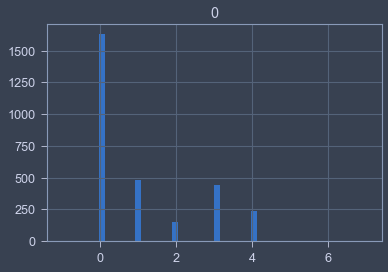

In [16]:
pd.DataFrame(np.array(train_out)).hist(bins=50, range=(-1,7))

Mamy niezabalansowany zbiór - zrobimy ważenie przykładów:

In [17]:
y_np = np.array(train_out) # classes
class_weights=compute_class_weight('balanced',classes=np.unique(y_np),y=y_np)
class_weights=torch.tensor(class_weights,dtype=torch.float)

print(class_weights)

tensor([0.3606, 1.2297, 3.8169, 1.3329, 2.4907])


#### Wydzielenie zbioru treningowego i walidacyjnego

In [18]:
BATCH_SIZE = 64
VALID_RATE = 0.15

In [19]:
np.random.seed(2115)
data_in_comp = torch.Tensor(train_in_padded).float()
eval_in = torch.Tensor(test_in_padded).float()
data_out_comp = torch.Tensor(train_out).long()

train_indices = np.random.rand(len(train_in_padded))>VALID_RATE
validate_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data_in_comp[train_indices], data_out_comp[train_indices])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

validate_set = torch.utils.data.TensorDataset(data_in_comp[validate_indices], data_out_comp[validate_indices])

validate_loader = DataLoader(validate_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torch.utils.data.TensorDataset(eval_in)

In [20]:
dat_cl = next(iter(train_loader))
val_cl = next(iter(validate_loader))
print(f"{dat_cl[0].shape=} | {dat_cl[1].shape=}")
print(f"{val_cl[0].shape=} | {val_cl[1].shape=}")

dat_cl[0].shape=torch.Size([64, 8966]) | dat_cl[1].shape=torch.Size([64])
val_cl[0].shape=torch.Size([64, 8966]) | val_cl[1].shape=torch.Size([64])


## Model

In [21]:
SEQ_LEN = max_len
SEQ_LEN

8966

In [22]:
NUM_CLASSESS = len(np.unique(np.array(train_out)))

In [23]:
class CompositorClassificator(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers_LSTM, out_size, bidirectional=False):
        super().__init__()
        self.num_layers_LSTM = num_layers_LSTM
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers_LSTM,
                            bidirectional=bidirectional)

        self.bn_lstm = nn.BatchNorm1d(SEQ_LEN * self.bidirectional * hidden_size)
        self.fc_classificator1 = nn.Linear(in_features=SEQ_LEN * self.bidirectional * hidden_size, out_features=800)
        self.act_1 = nn.Tanh()
        self.d_1 = nn.Dropout()
        self.bn_1 = nn.BatchNorm1d(800)

        self.fc_out = nn.Linear(in_features=800, out_features=out_size)

        self.act_out = nn.Tanh()

    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.num_layers_LSTM * self.bidirectional, batch_size, self.hidden_size)
        cell_state = torch.zeros(self.num_layers_LSTM * self.bidirectional, batch_size, self.hidden_size)
        return hidden_state, cell_state

    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        out = torch.flatten(all_outputs, 1)
        out = self.bn_lstm(out)

        out = self.bn_1(self.d_1(self.act_1(self.fc_classificator1(out))))
        out = self.fc_out(out)
        out = self.act_out(out)

        return out, hidden


model = CompositorClassificator(1, 10, 3, NUM_CLASSESS, False).to(device)

## Nauka

In [26]:
def count_loader_accuracy(val_model, val_loader):
    with torch.no_grad():
        val_outs = torch.Tensor()
        val_sum_ok = 0
        n_samples = 0
        for val_x, val_targets in val_loader:
            val_x = val_x.to(device).unsqueeze(2)
            val_hidden_state, val_cell_state = val_model.init_hidden(val_x.size(0))
            val_hidden_state, val_cell_state = val_hidden_state.to(device), val_cell_state.to(device)
            val_predictions, _ = val_model(val_x, (val_hidden_state,val_cell_state))
            val_predictions = torch.argmax(val_predictions,1).cpu()
            val_outs = torch.cat([val_outs, val_predictions], dim=0)
            val_sum_ok += (val_predictions == val_targets).sum().item()
            n_samples += val_x.size(0)
        return val_sum_ok/n_samples, val_outs

In [173]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
loss_fun = nn.CrossEntropyLoss(weight=class_weights.to(device))  # unballanced set
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

UWAGA: ze względu na to, że sieć pomimo dziesiątek uruchomień miała tendencję do przeuczania się (pomimo też wielu roznych architektur), postanowiliśmy zapisywać w trakcie uczenia model ktory ma najlepszy wynik a nie jest stosunkowo przeuczony. Dlatego też po uczeniu wczytywany jest model nie ostateczny, a taki który wydawał sie najlepszy w trakcie uczenia.

↓ SAVING ↓
Epoch: 0, training loss: 1.37, training accuracy: 0.532, validation accuracy: 0.538
Validation outputs class distribution:


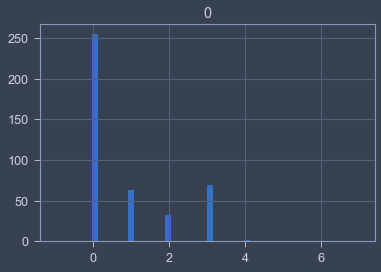

↓ SAVING ↓
Epoch: 1, training loss: 1.24, training accuracy: 0.6, validation accuracy: 0.595
Validation outputs class distribution:


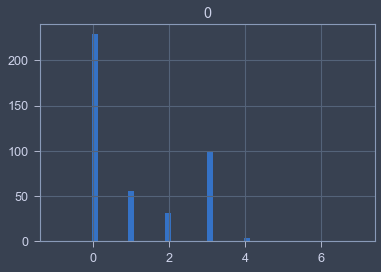

↓ SAVING ↓
Epoch: 2, training loss: 1.18, training accuracy: 0.638, validation accuracy: 0.629
Validation outputs class distribution:


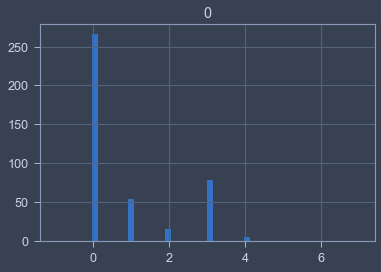

↓ SAVING ↓
Epoch: 3, training loss: 1.13, training accuracy: 0.64, validation accuracy: 0.64
Validation outputs class distribution:


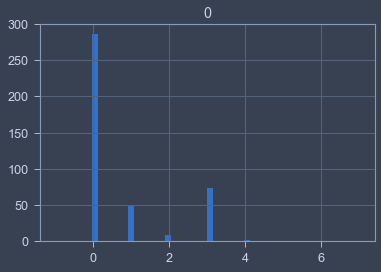

Epoch: 4, training loss: 1.1, training accuracy: 0.646, validation accuracy: 0.633
Validation outputs class distribution:


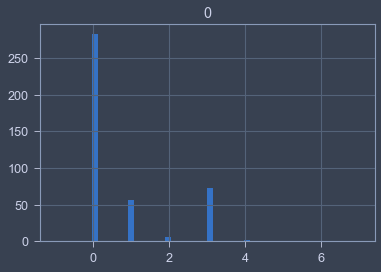

↓ SAVING ↓
Epoch: 5, training loss: 1.07, training accuracy: 0.647, validation accuracy: 0.645
Validation outputs class distribution:


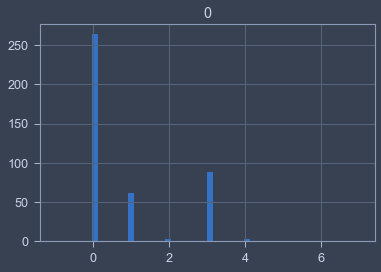

↓ SAVING ↓
Epoch: 6, training loss: 1.05, training accuracy: 0.659, validation accuracy: 0.657
Validation outputs class distribution:


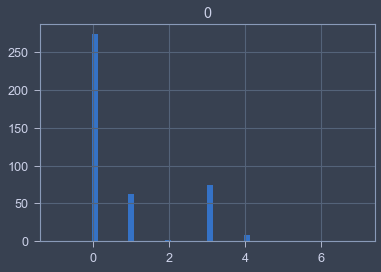

↓ SAVING ↓
Epoch: 7, training loss: 1.03, training accuracy: 0.661, validation accuracy: 0.671
Validation outputs class distribution:


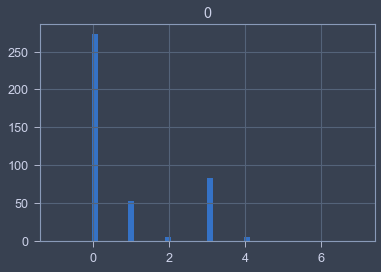

↓ SAVING ↓
Epoch: 8, training loss: 1.01, training accuracy: 0.681, validation accuracy: 0.679
Validation outputs class distribution:


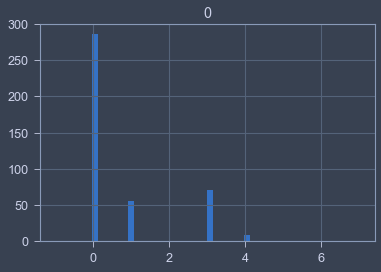

Epoch: 9, training loss: 0.983, training accuracy: 0.699, validation accuracy: 0.669
Validation outputs class distribution:


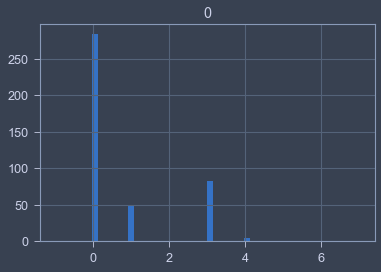

Epoch: 10, training loss: 0.957, training accuracy: 0.701, validation accuracy: 0.657
Validation outputs class distribution:


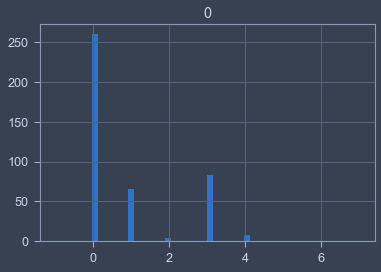

↓ SAVING ↓
Epoch: 11, training loss: 0.921, training accuracy: 0.724, validation accuracy: 0.683
Validation outputs class distribution:


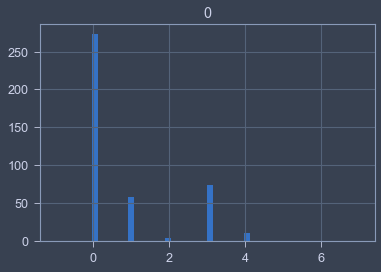

Epoch: 12, training loss: 0.881, training accuracy: 0.741, validation accuracy: 0.674
Validation outputs class distribution:


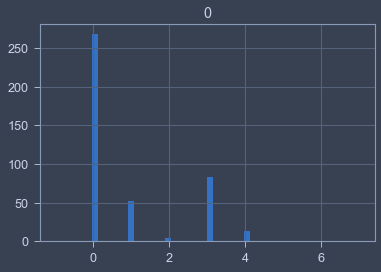

↓ SAVING ↓
Epoch: 13, training loss: 0.853, training accuracy: 0.76, validation accuracy: 0.698
Validation outputs class distribution:


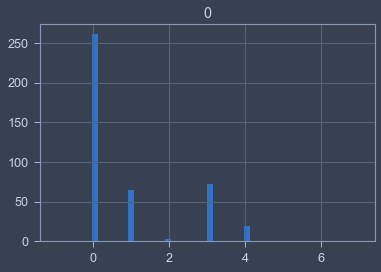

Epoch: 14, training loss: 0.811, training accuracy: 0.768, validation accuracy: 0.686
Validation outputs class distribution:


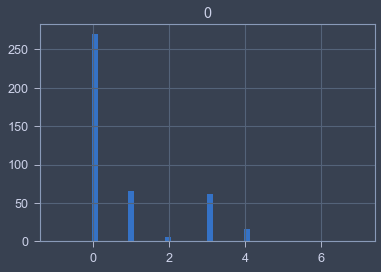

Epoch: 15, training loss: 0.795, training accuracy: 0.803, validation accuracy: 0.688
Validation outputs class distribution:


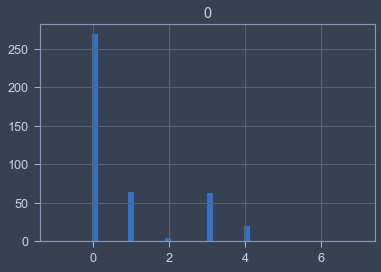

Epoch: 16, training loss: 0.766, training accuracy: 0.823, validation accuracy: 0.674
Validation outputs class distribution:


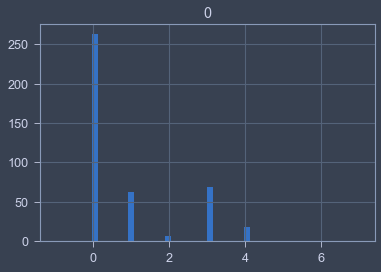

Epoch: 17, training loss: 0.736, training accuracy: 0.843, validation accuracy: 0.698
Validation outputs class distribution:


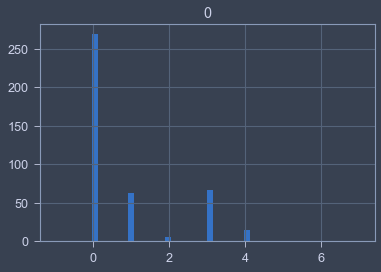

Epoch: 18, training loss: 0.713, training accuracy: 0.858, validation accuracy: 0.719
Validation outputs class distribution:


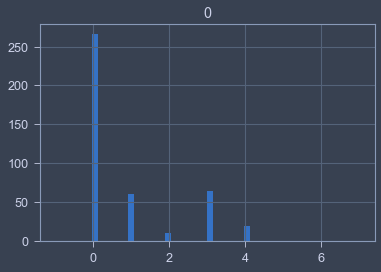

Epoch: 19, training loss: 0.686, training accuracy: 0.86, validation accuracy: 0.707
Validation outputs class distribution:


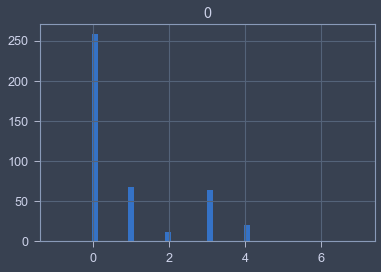

Epoch: 20, training loss: 0.671, training accuracy: 0.868, validation accuracy: 0.707
Validation outputs class distribution:


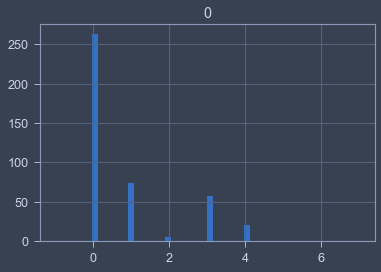

Epoch: 21, training loss: 0.66, training accuracy: 0.873, validation accuracy: 0.71
Validation outputs class distribution:


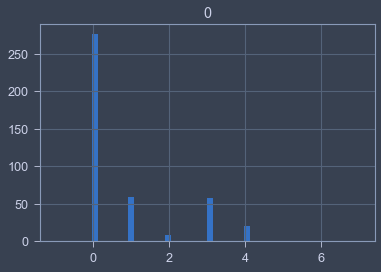

Epoch: 22, training loss: 0.642, training accuracy: 0.888, validation accuracy: 0.686
Validation outputs class distribution:


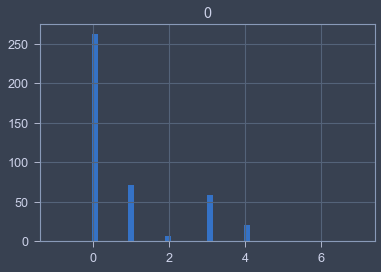

Epoch: 23, training loss: 0.626, training accuracy: 0.893, validation accuracy: 0.686
Validation outputs class distribution:


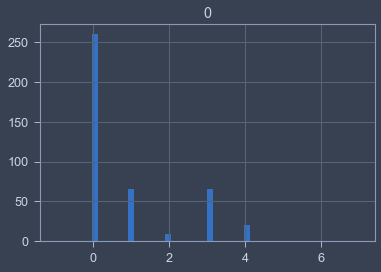

Epoch: 24, training loss: 0.612, training accuracy: 0.894, validation accuracy: 0.681
Validation outputs class distribution:


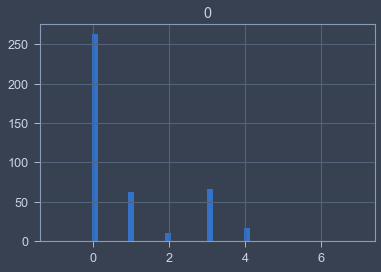

Epoch: 25, training loss: 0.611, training accuracy: 0.909, validation accuracy: 0.695
Validation outputs class distribution:


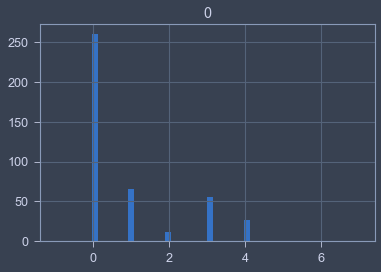

Epoch: 26, training loss: 0.591, training accuracy: 0.913, validation accuracy: 0.707
Validation outputs class distribution:


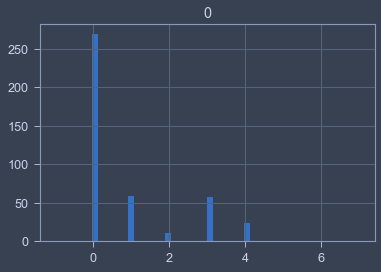

Epoch: 27, training loss: 0.586, training accuracy: 0.919, validation accuracy: 0.702
Validation outputs class distribution:


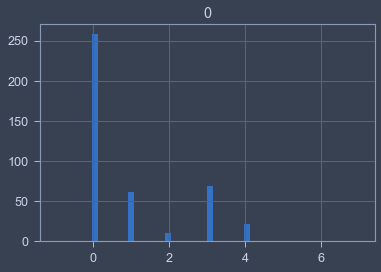

Epoch: 28, training loss: 0.581, training accuracy: 0.927, validation accuracy: 0.698
Validation outputs class distribution:


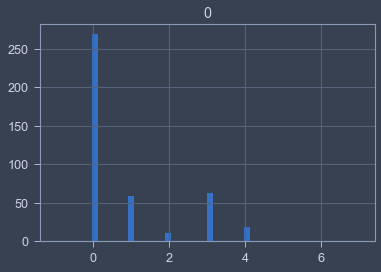

Epoch: 29, training loss: 0.571, training accuracy: 0.931, validation accuracy: 0.681
Validation outputs class distribution:


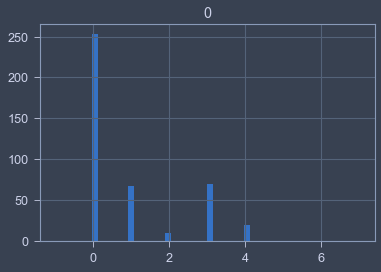

Epoch: 30, training loss: 0.561, training accuracy: 0.933, validation accuracy: 0.705
Validation outputs class distribution:


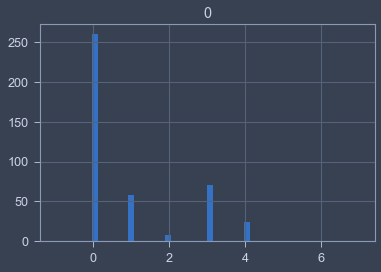

Epoch: 31, training loss: 0.554, training accuracy: 0.936, validation accuracy: 0.705
Validation outputs class distribution:


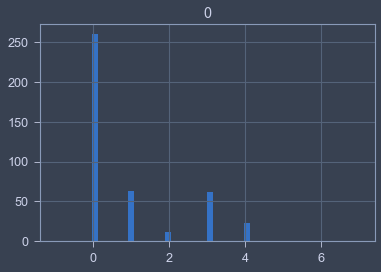

Epoch: 32, training loss: 0.547, training accuracy: 0.94, validation accuracy: 0.7
Validation outputs class distribution:


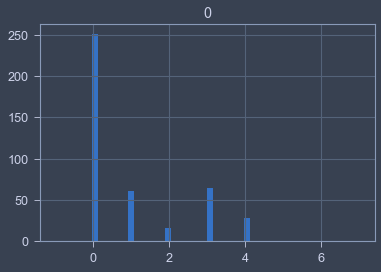

Epoch: 33, training loss: 0.545, training accuracy: 0.948, validation accuracy: 0.69
Validation outputs class distribution:


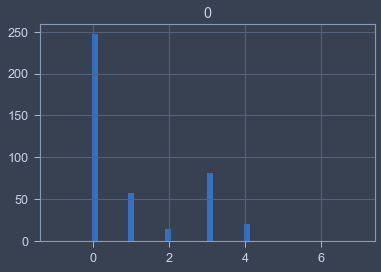

Epoch: 34, training loss: 0.542, training accuracy: 0.948, validation accuracy: 0.71
Validation outputs class distribution:


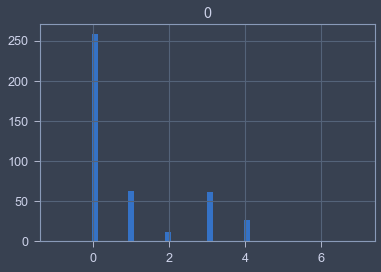

Epoch: 35, training loss: 0.54, training accuracy: 0.949, validation accuracy: 0.693
Validation outputs class distribution:


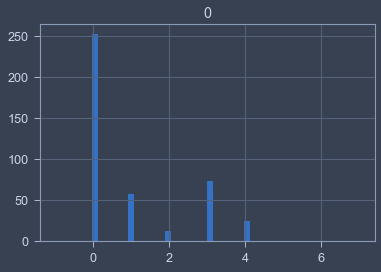

Epoch: 36, training loss: 0.531, training accuracy: 0.953, validation accuracy: 0.681
Validation outputs class distribution:


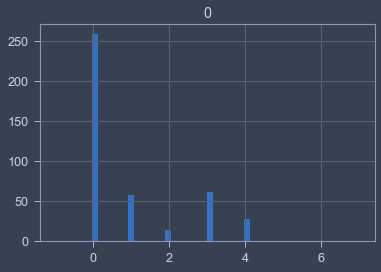

Epoch: 37, training loss: 0.52, training accuracy: 0.953, validation accuracy: 0.7
Validation outputs class distribution:


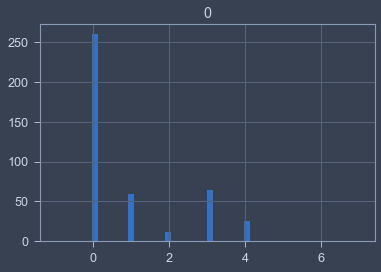

Epoch: 38, training loss: 0.521, training accuracy: 0.955, validation accuracy: 0.707
Validation outputs class distribution:


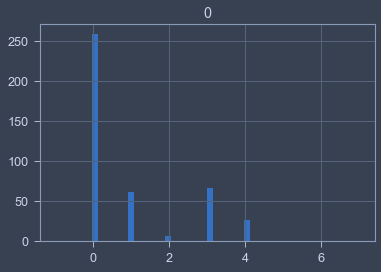

Epoch: 39, training loss: 0.518, training accuracy: 0.959, validation accuracy: 0.698
Validation outputs class distribution:


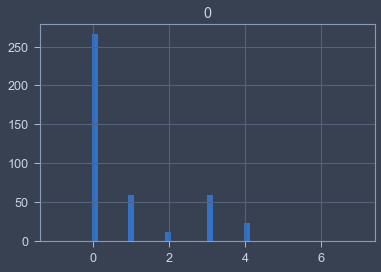

Epoch: 40, training loss: 0.514, training accuracy: 0.958, validation accuracy: 0.721
Validation outputs class distribution:


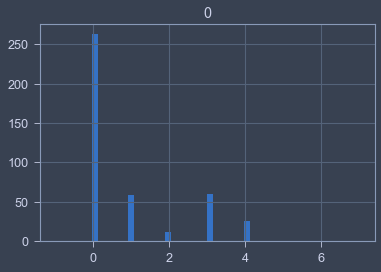

Epoch: 41, training loss: 0.519, training accuracy: 0.962, validation accuracy: 0.712
Validation outputs class distribution:


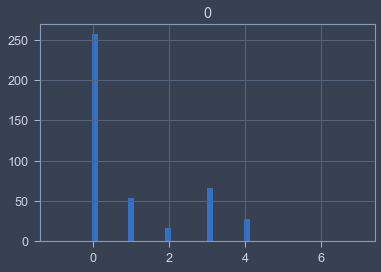

Epoch: 42, training loss: 0.51, training accuracy: 0.965, validation accuracy: 0.705
Validation outputs class distribution:


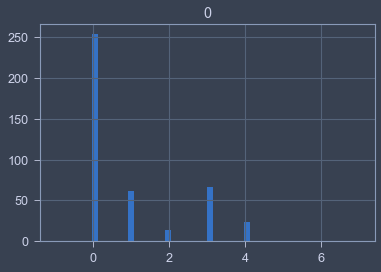

Epoch: 43, training loss: 0.509, training accuracy: 0.962, validation accuracy: 0.7
Validation outputs class distribution:


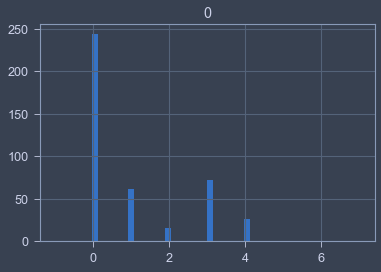

Epoch: 44, training loss: 0.505, training accuracy: 0.963, validation accuracy: 0.7
Validation outputs class distribution:


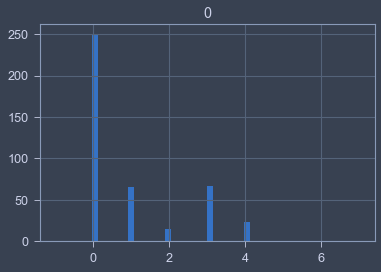

Epoch: 45, training loss: 0.504, training accuracy: 0.964, validation accuracy: 0.721
Validation outputs class distribution:


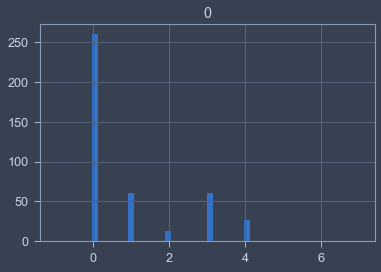

Epoch: 46, training loss: 0.5, training accuracy: 0.966, validation accuracy: 0.69
Validation outputs class distribution:


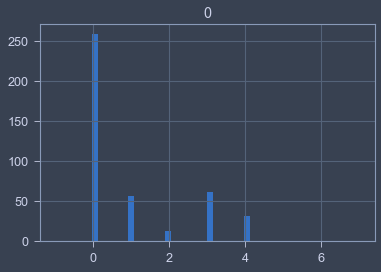

Epoch: 47, training loss: 0.501, training accuracy: 0.965, validation accuracy: 0.7
Validation outputs class distribution:


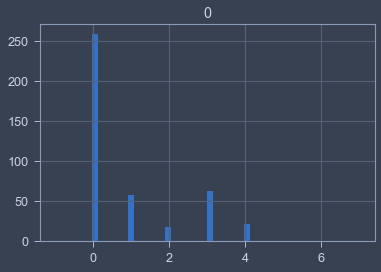

Epoch: 48, training loss: 0.494, training accuracy: 0.967, validation accuracy: 0.695
Validation outputs class distribution:


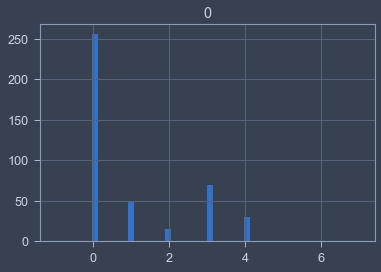

Epoch: 49, training loss: 0.489, training accuracy: 0.971, validation accuracy: 0.705
Validation outputs class distribution:


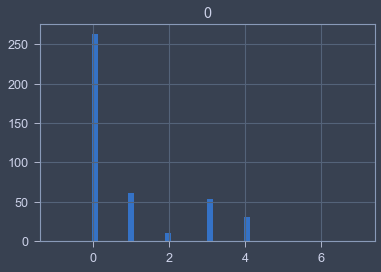

Epoch: 50, training loss: 0.491, training accuracy: 0.976, validation accuracy: 0.688
Validation outputs class distribution:


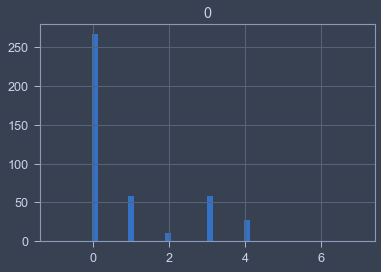

Epoch: 51, training loss: 0.492, training accuracy: 0.971, validation accuracy: 0.712
Validation outputs class distribution:


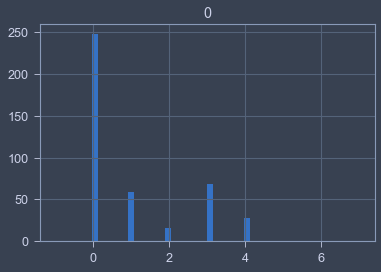

Epoch: 52, training loss: 0.488, training accuracy: 0.972, validation accuracy: 0.688
Validation outputs class distribution:


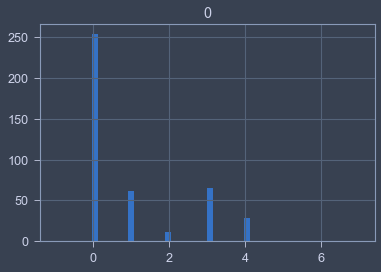

Epoch: 53, training loss: 0.484, training accuracy: 0.973, validation accuracy: 0.698
Validation outputs class distribution:


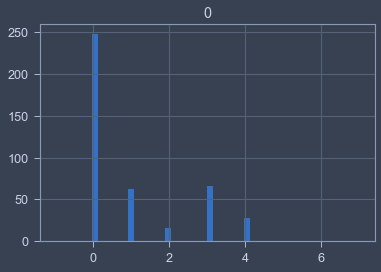

Epoch: 54, training loss: 0.485, training accuracy: 0.975, validation accuracy: 0.693
Validation outputs class distribution:


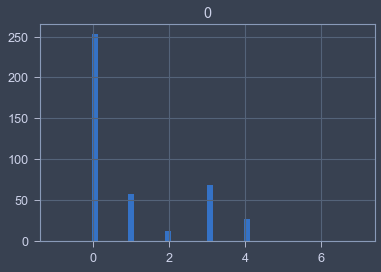

Epoch: 55, training loss: 0.485, training accuracy: 0.973, validation accuracy: 0.695
Validation outputs class distribution:


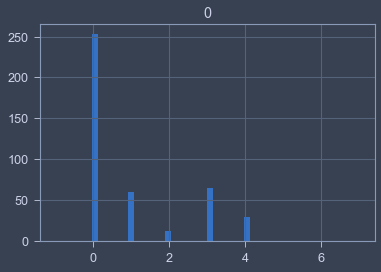

Epoch: 56, training loss: 0.483, training accuracy: 0.976, validation accuracy: 0.688
Validation outputs class distribution:


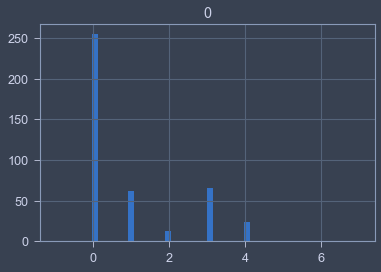

Epoch: 57, training loss: 0.479, training accuracy: 0.977, validation accuracy: 0.717
Validation outputs class distribution:


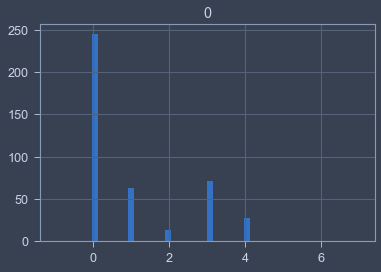

Epoch: 58, training loss: 0.478, training accuracy: 0.978, validation accuracy: 0.69
Validation outputs class distribution:


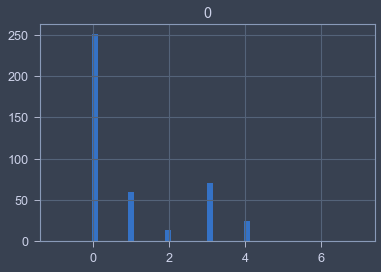

Epoch: 59, training loss: 0.475, training accuracy: 0.98, validation accuracy: 0.7
Validation outputs class distribution:


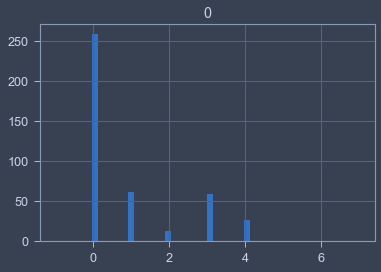

Epoch: 60, training loss: 0.475, training accuracy: 0.977, validation accuracy: 0.693
Validation outputs class distribution:


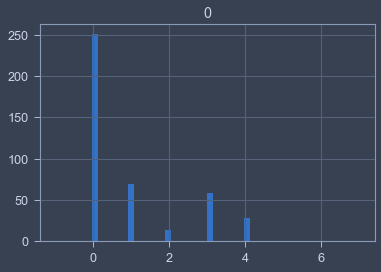

Epoch: 61, training loss: 0.483, training accuracy: 0.979, validation accuracy: 0.693
Validation outputs class distribution:


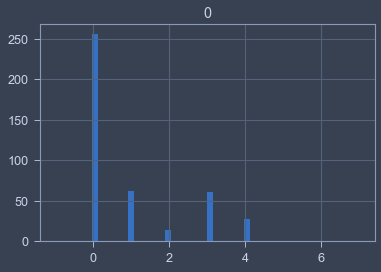

Epoch: 62, training loss: 0.476, training accuracy: 0.976, validation accuracy: 0.707
Validation outputs class distribution:


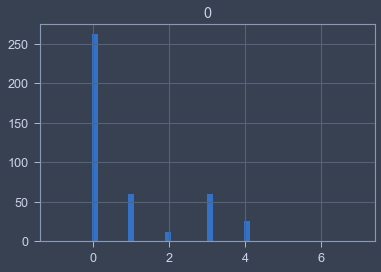

Epoch: 63, training loss: 0.477, training accuracy: 0.977, validation accuracy: 0.7
Validation outputs class distribution:


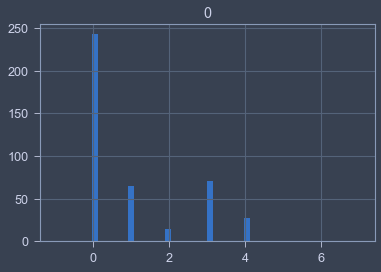

Epoch: 64, training loss: 0.477, training accuracy: 0.976, validation accuracy: 0.693
Validation outputs class distribution:


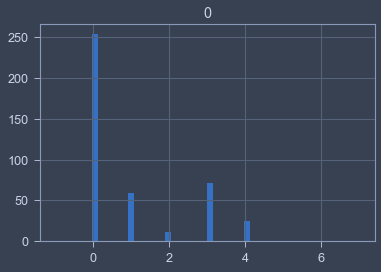

Epoch: 65, training loss: 0.474, training accuracy: 0.977, validation accuracy: 0.702
Validation outputs class distribution:


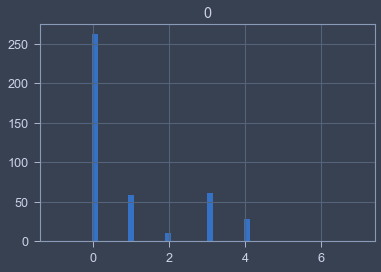

Epoch: 66, training loss: 0.474, training accuracy: 0.979, validation accuracy: 0.7
Validation outputs class distribution:


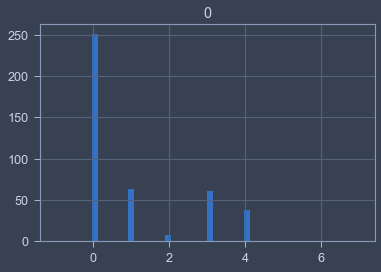

Epoch: 67, training loss: 0.473, training accuracy: 0.982, validation accuracy: 0.7
Validation outputs class distribution:


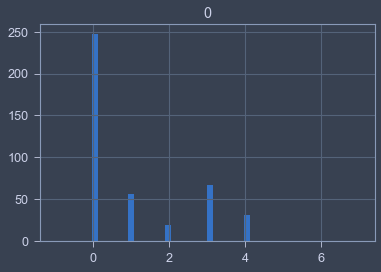

Epoch: 68, training loss: 0.477, training accuracy: 0.979, validation accuracy: 0.705
Validation outputs class distribution:


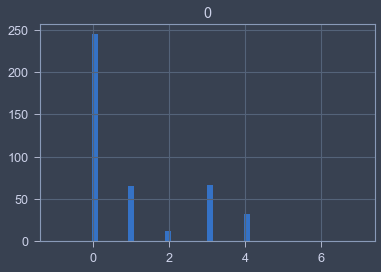

Epoch: 69, training loss: 0.472, training accuracy: 0.981, validation accuracy: 0.69
Validation outputs class distribution:


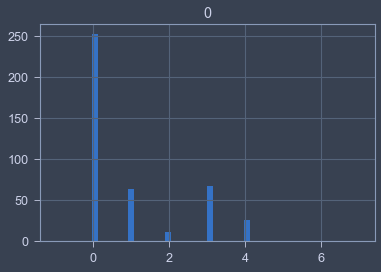

Epoch: 70, training loss: 0.47, training accuracy: 0.981, validation accuracy: 0.679
Validation outputs class distribution:


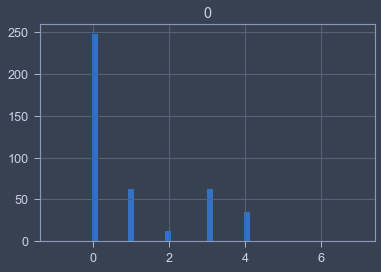

Epoch: 71, training loss: 0.472, training accuracy: 0.981, validation accuracy: 0.707
Validation outputs class distribution:


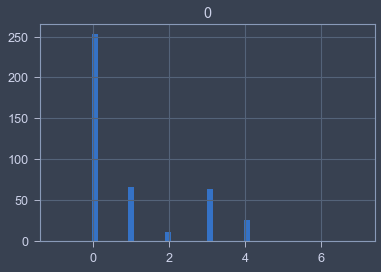

Epoch: 72, training loss: 0.47, training accuracy: 0.983, validation accuracy: 0.693
Validation outputs class distribution:


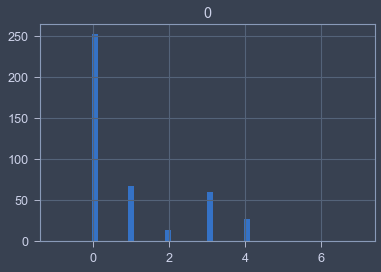

Epoch: 73, training loss: 0.472, training accuracy: 0.982, validation accuracy: 0.707
Validation outputs class distribution:


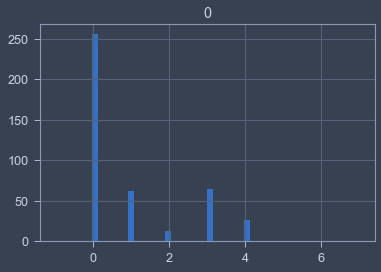

Epoch: 74, training loss: 0.469, training accuracy: 0.982, validation accuracy: 0.667
Validation outputs class distribution:


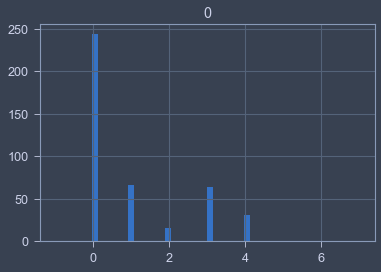

Epoch: 75, training loss: 0.47, training accuracy: 0.982, validation accuracy: 0.702
Validation outputs class distribution:


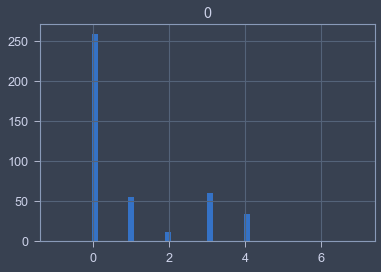

Epoch: 76, training loss: 0.467, training accuracy: 0.983, validation accuracy: 0.698
Validation outputs class distribution:


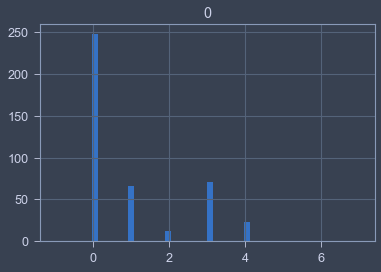

Epoch: 77, training loss: 0.466, training accuracy: 0.981, validation accuracy: 0.693
Validation outputs class distribution:


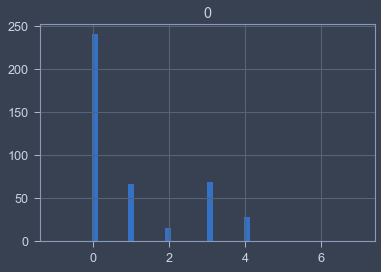

Epoch: 78, training loss: 0.465, training accuracy: 0.983, validation accuracy: 0.702
Validation outputs class distribution:


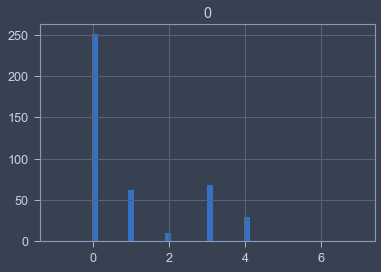

Epoch: 79, training loss: 0.465, training accuracy: 0.984, validation accuracy: 0.686
Validation outputs class distribution:


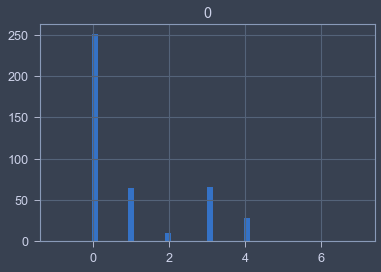

Epoch: 80, training loss: 0.465, training accuracy: 0.985, validation accuracy: 0.686
Validation outputs class distribution:


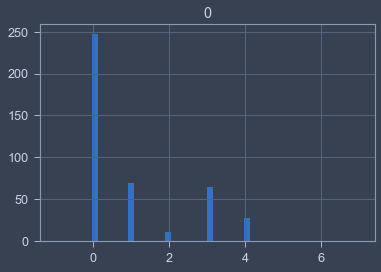

Epoch: 81, training loss: 0.464, training accuracy: 0.986, validation accuracy: 0.698
Validation outputs class distribution:


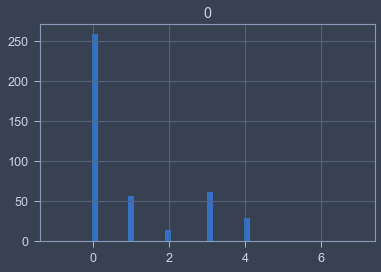

KeyboardInterrupt: 

In [174]:
losses = []
val_acc = []
train_acc = []
iters = []
best_val_acc = 0
for epoch in range(101):
    epoch_lossess = []
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden_state, cell_state = model.init_hidden(x.size(0))
        hidden_state, cell_state = hidden_state.to(device), cell_state.to(device)
        preds, _ = model(x, (hidden_state, cell_state))
        preds = preds.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()
        epoch_lossess.append(loss.item())
        optimizer.step()

    loss_mean = np.array(epoch_lossess).mean()

    current_train_acc, current_train_outs = count_loader_accuracy(model, train_loader)
    current_val_acc, current_val_outs = count_loader_accuracy(model, validate_loader)
    losses.append(loss_mean)
    iters.append(epoch)
    train_acc.append(current_train_acc)
    val_acc.append(current_val_acc)

    if current_val_acc > best_val_acc and current_train_acc - current_val_acc < 0.08:
        temp_state_dict = model.state_dict()
        print("↓ SAVING ↓")
        torch.save(temp_state_dict, f"model/model.tar")
        best_val_acc = current_val_acc

    # if epoch % 2 == 0:
    print(
        f"Epoch: {epoch}, training loss: {loss_mean:.3}, training accuracy: {current_train_acc:.3}, validation accuracy: {current_val_acc:.3}")
    print("Validation outputs class distribution:")
    pd.DataFrame(current_val_outs.cpu().detach().numpy()).hist(bins=50, range=(-1, 7))
    plt.show()
    scheduler.step()

--------------------
Final Training Accuracy: 0.9861055974593093
Final Validation Accuracy: 0.6976190476190476


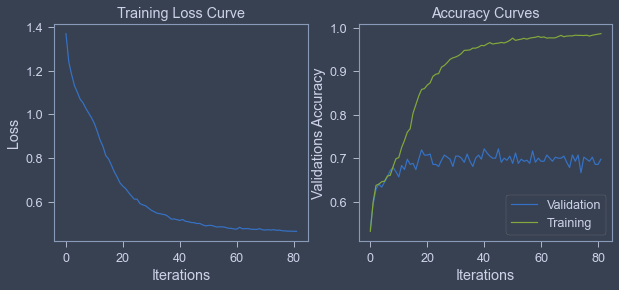

In [176]:
print("-" * 20)
print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Training Loss Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.title("Accuracy Curves")
plt.plot(iters, val_acc, label="Validation")
plt.plot(iters, train_acc, label="Training")
plt.xlabel("Iterations")
plt.ylabel("Validations Accuracy")
plt.legend(loc='best')
plt.show()

## Ewaluacja modelu

Załadowanie stanu modelu, który miał najlepsze accuracy, gdy nie był jeszcze przeuczony:

In [50]:
model_eval = CompositorClassificator(1, 10, 3, NUM_CLASSESS, False).to(device)
state_dict = torch.load(f"model/model.tar")
model_eval.load_state_dict(state_dict)

<All keys matched successfully>

Przypomnienie jego wyników:

In [51]:
train_acc, _ = count_loader_accuracy(model_eval, train_loader)
val_acc, _ = count_loader_accuracy(model_eval, validate_loader)
print(f"{train_acc=}")
print(f"{val_acc=}")

train_acc=0.7522826518459707
val_acc=0.6952380952380952


Zbiór ewaluacyjny:

In [52]:
from torch.utils.data import TensorDataset

with open('data/test_no_target.pkl', 'rb') as f:
    dataset_test = pickle.load(f)
data = []
for d in dataset_test:
    data.append(torch.tensor(d))

data_padded = pad_sequence(data, batch_first=True, padding_value=0)
data_padded = torch.tensor(data_padded).float()

test_dataset = TensorDataset(data_padded, data_padded)

C:\Users\01149762\AppData\Local\Temp/ipykernel_15700/1549495772.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_padded = torch.tensor(data_padded).float()


In [39]:
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [40]:
sample = next(iter(test_loader))

In [42]:
sample[0].shape

torch.Size([32, 8966])

In [43]:
outs3 = torch.Tensor()
with torch.no_grad():
    for x3 in test_loader:
        x3 = x3[0].to(device).unsqueeze(2)
        hidden_state3, cell_state3 = model_eval.init_hidden(x3.size(0))
        hidden_state3, cell_state3 = hidden_state3.to(device), cell_state3.to(device)
        preds3, _ = model_eval(x3, (hidden_state3,cell_state3))
        preds3 = torch.argmax(preds3.squeeze(1),1).cpu()
        print(preds3)
        outs3 = torch.cat([outs3, preds3], dim=0).int()

tensor([4, 0, 0, 3, 0, 1, 3, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0])
tensor([0, 3, 0, 0, 0, 1, 1, 0, 3, 4, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 3, 0,
        0, 0, 0, 1, 0, 0, 0, 0])
tensor([3, 3, 1, 3, 0, 1, 1, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 0, 0, 4])
tensor([0, 0, 3, 4, 1, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 1, 3, 3, 4, 0, 0, 3])
tensor([4, 4, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 1,
        1, 0, 0, 3, 1, 0, 3, 0])
tensor([0, 0, 0, 0, 3, 1, 0, 3, 0, 0, 3, 0, 0, 1, 3, 0, 0, 4, 0, 0, 0, 0, 0, 3,
        0, 0, 4, 0, 0, 0, 1, 3])
tensor([0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 1, 0, 1, 1,
        3, 0, 1, 0, 0, 3, 0, 0])
tensor([2, 0, 1, 0, 0, 3, 0, 3, 0, 1, 1, 1, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 4, 0, 0, 3, 0, 0])
tensor([0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 3, 4, 3, 0, 3, 3, 1, 0, 0,
        0, 4, 0,

Rozkład wyników:

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

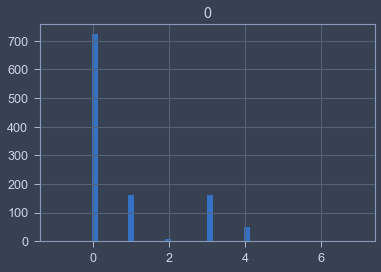

In [44]:
pd.DataFrame(outs3.cpu().detach().numpy()).hist(bins=50, range=(-1,7))

Niestety pomimo zastosowania ważenia przykładów, klasa 2 została pochłonięta.

Zapisanie wyników do pliku:

In [45]:
df_out = pd.DataFrame(outs3)
df_out

,0
0,4
1,0
2,0
3,3
4,0
...,...
1098,0
1099,3
1100,3
1101,0


In [46]:
csv = df_out.to_csv(index=False, header=False)
with open('results.csv', 'w', newline="") as f:
    f.write(csv)